In [1]:
# Utils
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt

import numpy as np
import time
#import _pickle as pickle
import pickle
import re, sys, unidecode
#import unidecode

# Representation
import nltk
from nltk.corpus import stopwords
import scikitplot.plotters as skplt


plt.style.use('fivethirtyeight')


/root/anaconda3/lib/python3.6/site-packages/tensorflow/python/_pywrap_tensorflow_internal.so | _pywrap_tensorflow_internal


# Load Data

In [2]:
root_path = "../"
path_data_raw = root_path + "data/raw/"
dfNoticias = pd.read_pickle(path_data_raw+"dfNoticias")

# Data info

In [3]:
dfNoticias.head()

Cuerpo     Fecha   Hora  \
1  \nMarcel Granollers (44°) sorprendió a David F...  20140929  09:57   
2  \nEl Gobierno de Barack Obama ha enviado cuatr...  20140929  07:03   
3  \nEste miércoles la Comisión Asesora Presidenc...  20140929  11:37   
4  \nWolfgang Burmann, del Team Avanti, se adjudi...  20140929  10:05   
5  \nWolfgang Burmann, del Team Avanti, se adjudi...  20140929  10:05   

               ID                                            Resumen  \
1  20140929095927  \nEl español cayó ante su compatriota Marcel G...   
2  20140929065051  \nLas conversaciones comenzaron el año 2010 y ...   
3  20140929105234  \nRepresentantes del sector privado acusaron q...   
4  20140929100825  \nEl pedalero del equipo Avanti terminó en el ...   
5  20140929130450  \nEl pedalero del equipo Avanti terminó en el ...   

  Seccion_1 Seccion_2 Seccion_3    Subtema_1              Subtema_2 Subtema_3  \
1  Deportes      None      None  Torneos ATP                   None      None   
2      País     Mundo     Mundo       EE.UU.  Relaciones Exteriores      None   
3      País      None      None       Isapre                   None      None   
4  Deportes      None      None     Chilenos                   None      None   
5  Deportes      None      None     Chilenos                   None      None   

                  Tema_1  Tema_2 Tema_3  \
1                  Tenis    None   None   
2  Relaciones Exteriores  EE.UU.   Cuba   
3                  Salud    None   None   
4               Ciclismo    None   None   
5               Ciclismo    None   None   

                                             Titular         Type  
1  \nDavid Ferrer sufrió otra temprana eliminación\n  fid_noticia  
2  \nObama ha enviado cuatro solicitudes a Chile ...  fid_noticia  
3  \nQuiebre en comisión presidencial de isapres ...  fid_noticia  
4  \nWolfgang Burmann ganó el segundo clasificato...  fid_noticia  
5  \nWolfgang Burmann ganó el segundo clasificato...  fid_noticia

In [4]:
dfNoticias.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 250759 entries, 1 to 389889
Data columns (total 16 columns):
Cuerpo       250639 non-null object
Fecha        250759 non-null object
Hora         250759 non-null object
ID           250759 non-null object
Resumen      249632 non-null object
Seccion_1    250459 non-null object
Seccion_2    123240 non-null object
Seccion_3    37532 non-null object
Subtema_1    182753 non-null object
Subtema_2    74385 non-null object
Subtema_3    24247 non-null object
Tema_1       248508 non-null object
Tema_2       116973 non-null object
Tema_3       36153 non-null object
Titular      250759 non-null object
Type         250759 non-null object
dtypes: object(16)
memory usage: 32.5+ MB


### elementos nulos

Existen noticias con el cuerpo en nulo, primeras en ser borradas.
Tambien con seccion_1 en nulo, borrar tambien.

In [5]:
pd.isnull(dfNoticias).any()

Cuerpo        True
Fecha        False
Hora         False
ID           False
Resumen       True
Seccion_1     True
Seccion_2     True
Seccion_3     True
Subtema_1     True
Subtema_2     True
Subtema_3     True
Tema_1        True
Tema_2        True
Tema_3        True
Titular      False
Type         False
dtype: bool

### Cantidades totales por cada columnas, cantidad de elementos no repetidos, elemento mas repetido y la cantidad de veces que se repite este

Aca se pueden ver las cantidades de noticias etiquetadas y la cantidad de etiquetas, para seccionx, temax y subtemaX

620 noticias con cuerpo repetido, "/n/n", borrar tambien.

In [6]:
dfNoticias.describe(include="all")

Cuerpo     Fecha    Hora              ID Resumen Seccion_1 Seccion_2  \
count   250639    250759  250759          250759  249632    250459    123240   
unique  238968      2171    1416          250759  236300         9        10   
top       \n\n  20110621   00:01  20150430222925    \n\n  Deportes  Deportes   
freq       620       183     924               1    1206     80576     58249   

       Seccion_3  Subtema_1          Subtema_2                Subtema_3  \
count      37532     182753              74385                    24247   
unique         9       1481               1270                      902   
top     Deportes  Colo Colo  Selección chilena  Chilenos en el exterior   
freq       20668       3312               2114                     1076   

        Tema_1  Tema_2  Tema_3               Titular         Type  
count   248508  116973   36153                250759       250759  
unique     237     237     219                239031            1  
top     Fútbol  Fútbol  Fútbol  \nEstrenos de cine\n  fid_noticia  
freq     43438   35295   14165                    36       250759

### Ejemplo texto de una noticia
Falta limpar html en texto, caracteres como /n

In [7]:
dfNoticias["Cuerpo"].iloc[100]

'\nLa serie de televisión "Miami Vice" cumple 30 años, y desde su creación ha sido considerada la plataforma que dio a conocer ante el mundo a esta glamourosa ciudad del sureste de Estados Unidos y que también la ayudó a resurgir.\nCon una trama que combinó la moda y los lujosos convertibles, yates y hoteles con problemas de tráfico de cocaína y prostitución, la cadena NBC dio a conocer esta ciudad de Florida que durante los años ochenta estaba en decadencia.\n"Miami Vice fue un show increíble, porque cambió completamente la imagen de Miami en el mundo", dijo recientemente el conocido productor musical cubanoamericano Emilio Estefan, quien hace eco del impacto que ha tenido la serie en la arquitectura, la moda y el diseño de la ciudad durante las últimas tres décadas.\nLa serie, que se transmitió durante más de 5 años, a partir de septiembre de 1984, ha tenido desde entonces una gran influencia que ha perdurado como todo un fenómeno de la cultura pop estadounidense.\nVestidos de forma 

# Analisis Etiquetas

In [8]:
def labels_info(labels_name):
    labels_count=dfNoticias[labels_name].value_counts(ascending=True)
    total = len(labels_count)
    labels_count.plot.barh(color='DarkOrange',
                           figsize=(10,round(total/2)),
                           title="Labels " + labels_name + ", total "+ str(total),
                           grid=True)


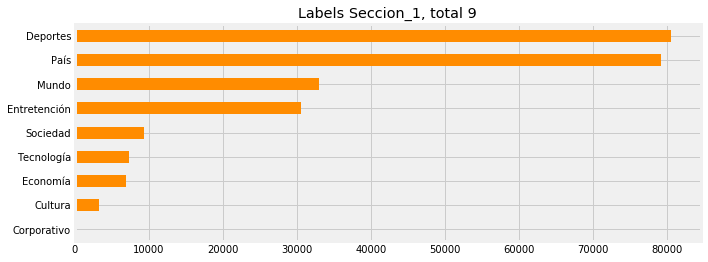

In [9]:
labels_info("Seccion_1")


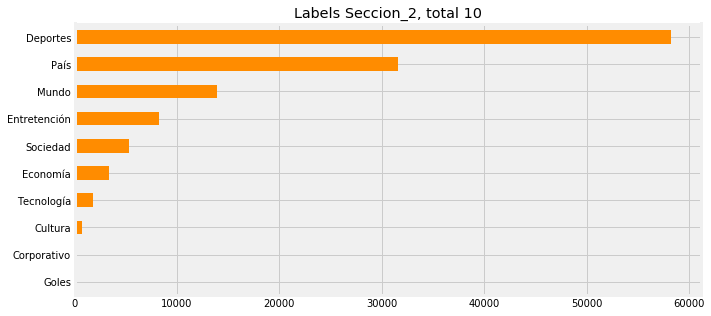

In [10]:
labels_info("Seccion_2")


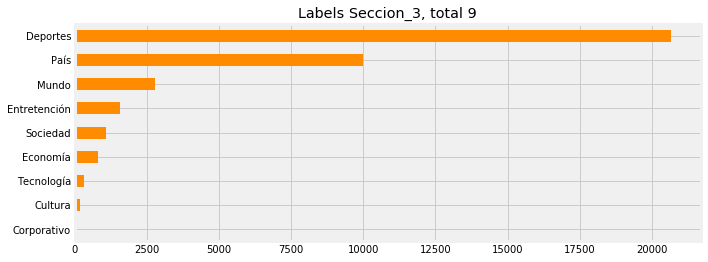

In [11]:
labels_info("Seccion_3")


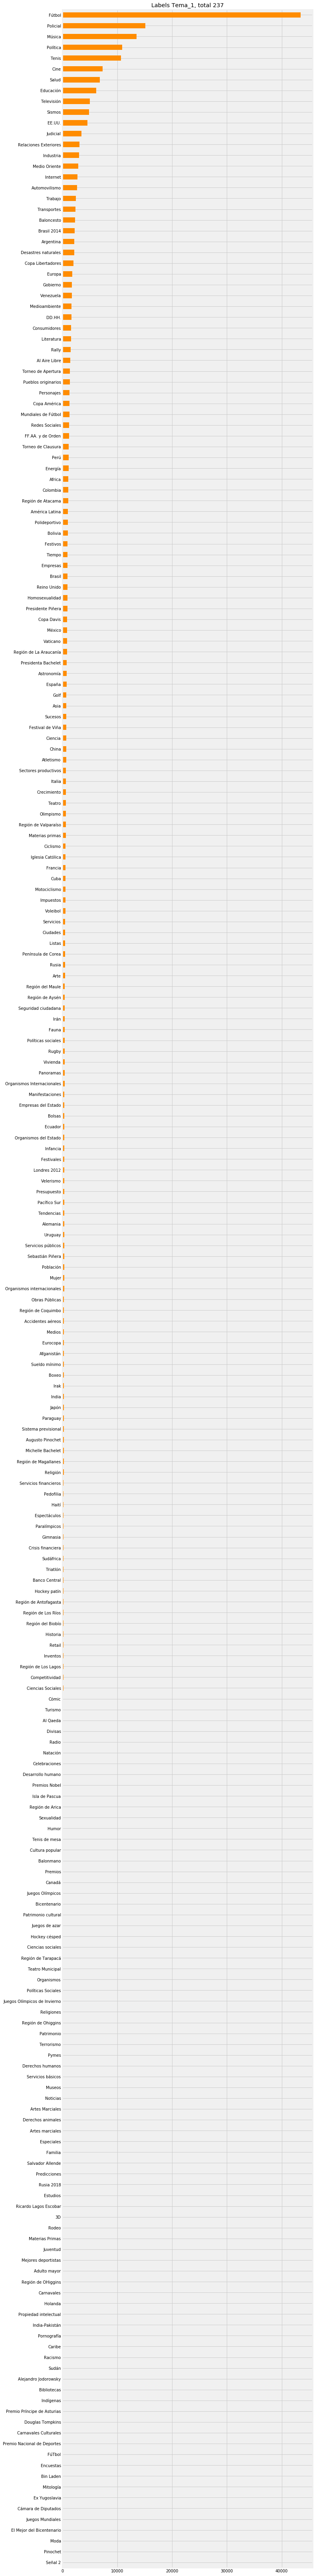

In [12]:
labels_info("Tema_1")


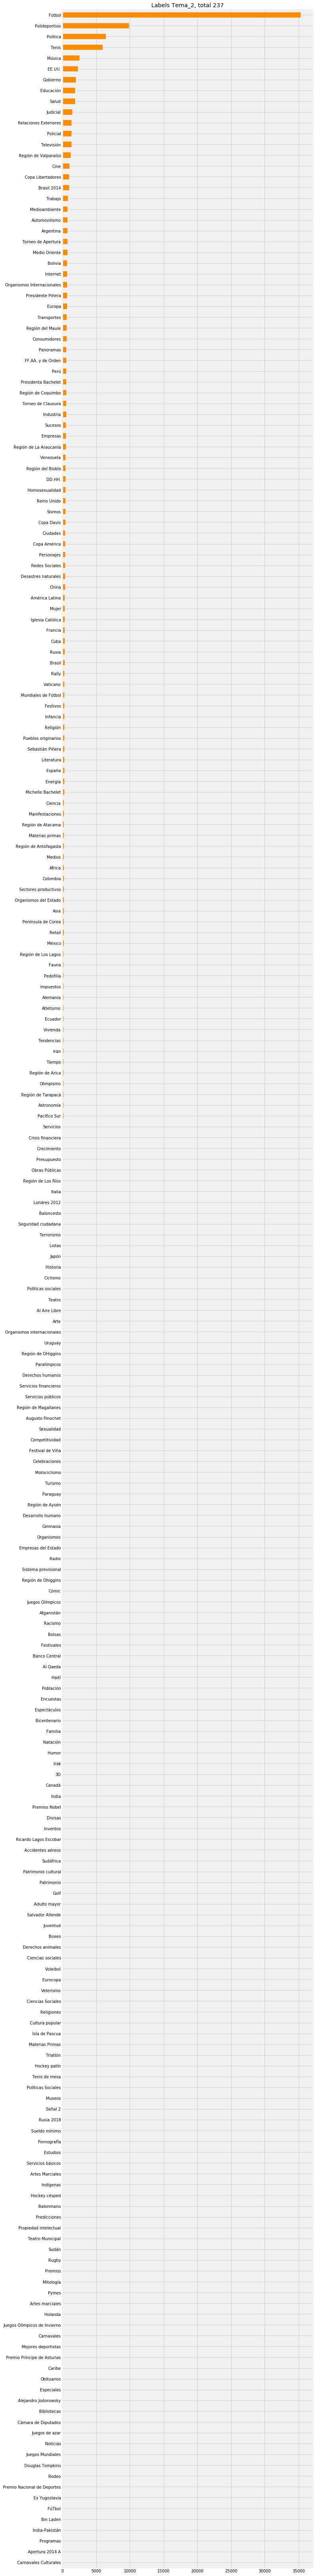

In [13]:
labels_info("Tema_2")


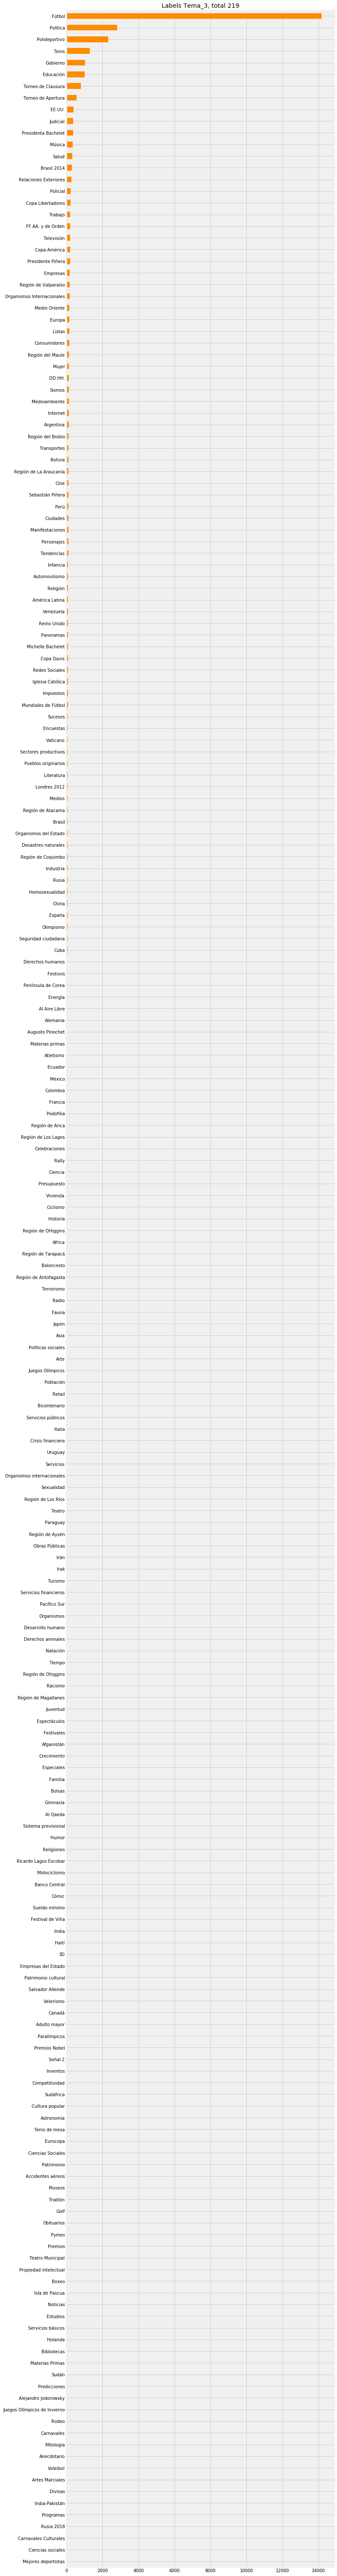

In [14]:
labels_info("Tema_3")


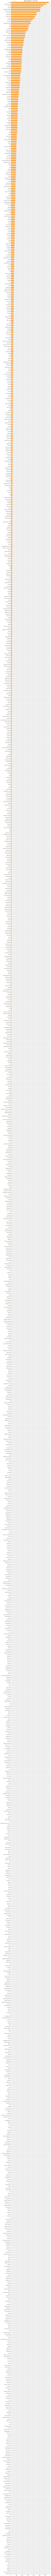

In [15]:
labels_info("Subtema_1")


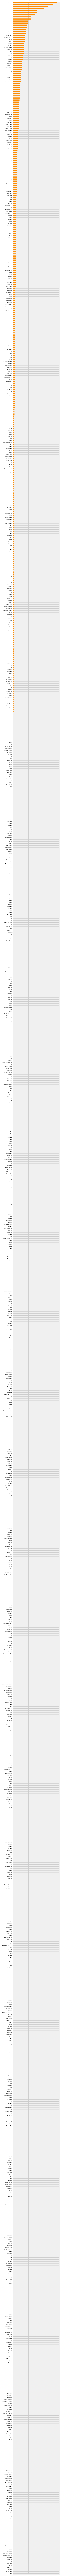

In [16]:
labels_info("Subtema_2")


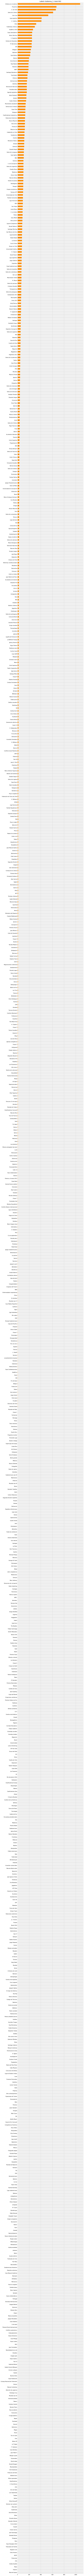

In [17]:
labels_info("Subtema_3")


### Largos de noticias

Histograma, muy pocas noticas arriba de 2000 palabras. grafico distorsionado por noticias muy largas (mas de 2000 palabras)

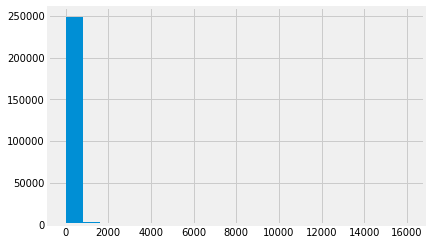

In [18]:
dfNoticias["Cuerpo"].map(lambda x:len(str(x).split(" ")), na_action=None).hist(bins=20)

### hist solo noticias con menos de mil palabras 

In [19]:
# Añador largo de noticias como campo en var tmp
dfNoticiasTmp = dfNoticias.copy()
words_cuerpo = dfNoticiasTmp["Cuerpo"].map(lambda x:len(str(x).split(" ")), na_action=None)
dfNoticiasTmp["largo_noticia"] = words_cuerpo.values

cantiadad noticias con mas de 1000 palabras : 1029


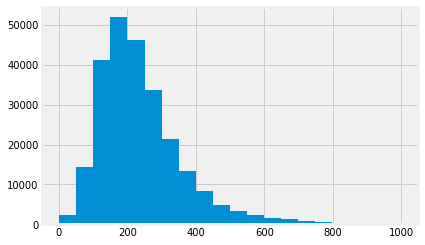

In [20]:
filtered_data = dfNoticiasTmp[dfNoticiasTmp.largo_noticia < 1000]
filtered_data["Cuerpo"].map(lambda x:len(str(x).split(" ")), na_action=None).hist(bins=20)
print( "cantiadad noticias con mas de 1000 palabras : " + str(dfNoticias.shape[0] - filtered_data.shape[0]) )


# Cleaning

Limpieza de datos
* Cuerpo en null
* seccion 1 en null
* cuerpo igual a /n/n
* noticias repetidas


In [21]:
dfNoticiasClean = dfNoticias
dfNoticiasClean = dfNoticiasClean.dropna(subset=['Cuerpo', 'Seccion_1'])
print( "noticias eliminadas,  sin cuerpo o label : "+ str( dfNoticias.shape[0]-dfNoticiasClean.shape[0] ))

noticias eliminadas,  sin cuerpo o label : 420


In [22]:
tmp = dfNoticiasClean.shape[0]
dfNoticiasClean = dfNoticiasClean[dfNoticiasClean.Cuerpo != "\n\n"]
print( "noticias eliminadas,  con cuerpo igual a '/n/n' : "+ str( tmp-dfNoticiasClean.shape[0] ))

noticias eliminadas,  con cuerpo igual a '/n/n' : 387


In [23]:
print("cantidad noticias con cuerpo repetido : " + str( sum(dfNoticiasClean.duplicated(subset=['Cuerpo']))))


cantidad noticias con cuerpo repetido : 11051


In [24]:
print("cantidad noticias con todos los campos repetidos : " + str(sum(dfNoticiasClean.duplicated(subset=['Cuerpo', 'Seccion_1','Tema1','Subtema_1','Seccion_2','Tema2','Subtema_2','Seccion_3','Tema3','Subtema_3']))) )


cantidad noticias con todos los campos repetidos : 11042


Borro noticas repetidas

In [25]:

dfNoticiasClean = dfNoticiasClean.drop_duplicates(subset=['Cuerpo'])

## limpiado etiquetas

* remuevo categoria goles en seccion 2 , error en etiquetado
* remuevo caracteres no alpha-num, puntuacion y paso a minusculas

In [26]:
dfNoticiasClean = dfNoticiasClean[dfNoticiasClean.Seccion_2 !='Goles']

In [27]:
dfNoticiasClean.describe(exclude=[np.number])

Cuerpo     Fecha    Hora  \
count                                              238900    238900  238900   
unique                                             238900      2171    1415   
top     \nLa nave automática espacial rusa Progress M-...  20110831   00:01   
freq                                                    1       180     900   

                    ID Resumen Seccion_1 Seccion_2 Seccion_3  Subtema_1  \
count           238900  237864    238900    117007     35507     174621   
unique          238900  235824         9         9         9       1480   
top     20150430222925    \n\n  Deportes  Deportes  Deportes  Colo Colo   
freq                 1     919     76456     55404     19730       3128   

                Subtema_2                Subtema_3  Tema_1  Tema_2  Tema_3  \
count               70744                    23012  237061  110943   34191   
unique               1270                      902     236     236     219   
top     Selección chilena  Chilenos en el exterior  Fútbol  Fútbol  Fútbol   
freq                 1959                     1030   41248   33555   13487   

                     Titular         Type  
count                 238900       238900  
unique                238261            1  
top     \nEstrenos de cine\n  fid_noticia  
freq                      35       238900

Limpio texto de etiquetas clase y subclase, mas de 100 clases repetidas encontradas despues de la limpieza

In [29]:
def simple_clean(string):
    if type(string) == str :
        string = ''.join(x for x in string if (x.isalpha() or x ==" " ) )
        string= string.lower()
        return unidecode.unidecode(string)
    else:
        return string

In [36]:
clases = ["Seccion_1","Seccion_2","Seccion_3","Tema_1","Tema_2","Tema_3","Subtema_1","Subtema_2","Subtema_3"]

for column in clases:
    dfNoticiasClean[column] = dfNoticiasClean[column].map( simple_clean , na_action=None)

dfNoticiasClean.describe(exclude=[np.number])

Cuerpo     Fecha    Hora  \
count                                              238900    238900  238900   
unique                                             238900      2171    1415   
top     \nLa nave automática espacial rusa Progress M-...  20110831   00:01   
freq                                                    1       180     900   

                    ID Resumen Seccion_1 Seccion_2 Seccion_3  Subtema_1  \
count           238900  237864    238900    117007     35507     174621   
unique          238900  235824         9         9         9       1454   
top     20150430222925    \n\n  deportes  deportes  deportes  colo colo   
freq                 1     919     76456     55404     19730       3128   

                Subtema_2                Subtema_3  Tema_1  Tema_2  Tema_3  \
count               70744                    23012  237061  110943   34191   
unique               1251                      888     229     229     215   
top     seleccion chilena  chilenos en el exterior  futbol  futbol  futbol   
freq                 2060                     1030   41251   33556   13487   

                     Titular         Type  
count                 238900       238900  
unique                238261            1  
top     \nEstrenos de cine\n  fid_noticia  
freq                      35       238900

# guardado data limpia

In [37]:
pickle.dump( dfNoticiasClean, open( root_path + "data/clean/dfNoticiasClean.p", "wb" ) )